In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platforms", 'cpu')

from ImageD11.unitcell import unitcell
from ImageD11.parameters import AnalysisSchema
from ImageD11.columnfile import columnfile

In [2]:
import ImageD11
asc = ImageD11.unitcell.Phases.from_json('pars.json')
ucell = asc.unitcells['Cu']
ucell

Cu | [ 3.615  3.615  3.615 90.    90.    90.   ] | 225

In [3]:
pars = asc.geometry_pars_obj

In [4]:
np.sqrt(100e6)

10000.0

In [5]:
npx = 10_000

In [6]:
pars.set('distance', 50e3)  # 130 mm
pars.set('wavelength', 0.1771)
pars.set('y_center', npx//2)
pars.set('z_center', npx//2)
pars.set('chi', 0)
pars.set('wedge', 0)
pars.set('y_size', 2.5)
pars.set('z_size', 2.5)
pars.set('tilt_x', 0)
pars.set('tilt_y', 0)
pars.set('tilt_z', 0)

In [7]:
pars.get_parameters()

{'chi': 0,
 'distance': 50000.0,
 'fit_tolerance': 0.05,
 'min_bin_prob': 1e-05,
 'no_bins': 10000,
 'o11': -1,
 'o12': 0,
 'o21': 0,
 'o22': -1,
 'omegasign': 1.0,
 't_x': 0.0,
 't_y': 0.0,
 't_z': 0.0,
 'tilt_x': 0,
 'tilt_y': 0,
 'tilt_z': 0,
 'wavelength': 0.1771,
 'wedge': 0,
 'weight_hist_intensities': 'False',
 'y_center': 5000,
 'y_size': 2.5,
 'z_center': 5000,
 'z_size': 2.5}

In [8]:
import Dans_Diffraction as dif

crystal = dif.Crystal('EntryWithCollCode7954_scaled.cif')
crystal.Scatter.setup_scatter(scattering_type='xray',
                              wavelength_a=asc.geometry_pars_obj.get('wavelength'), 
                              powder_units='twotheta',
                              min_twotheta=0.1,
                              max_twotheta=30,
                              min_theta=-np.inf,
                              max_theta=np.inf
                             )

Scatter(EntryWithCollCode7954_scaled with 1 atomic positions, 192 symmetries)
       Type: xray
     Energy: 70.00814733413704 keV
 Wavelength: 0.17709999999999998 A
 ---Settings---
      Powder units: twotheta
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -inf
         max theta: inf
      min twotheta: 0.1
      max twotheta: 30
 ---X-Ray Settings---
 Waasmaier scattering factor: False
 ---Neutron Settings---
 Sears (ITC) scattering lengths: False
 ---Magnetic Settings---
   Mag. scattering: True
  Mag. form factor: True
         Polarised: False
      Polarisation: sp
       Pol. vector: (0,1,0)
 ---Resonant Settings---
   Azimuthal angle: 0
    Azimuthal ref.: (1,0,0)
               flm: (0,1,0)
  use e1e1 approx.: True



In [9]:
ref_ucell = ucell

In [10]:
# ref_ucell = unitcell([2.8, 2.8, 2.8, 90, 90, 90], 229)  # BCC Fe

In [11]:
ref_ucell.makerings(1.5)
hkls = []
mults = []
for i, d in enumerate(ref_ucell.ringds):
    hklring = ref_ucell.ringhkls[d]
    mults.append( len(hklring) )
    print(i, len(hklring),hklring[0],d)
    hkls += list(hklring)

hkls = np.array(hkls)

0 8 (-1, -1, -1) 0.47912885409927447
1 6 (-2, 0, 0) 0.5532503457814661
2 12 (0, -2, -2) 0.7824141423917538
3 24 (-1, -3, -1) 0.9174619060457537
4 8 (-2, -2, -2) 0.9582577081985489
5 6 (0, -4, 0) 1.1065006915629323
6 24 (-3, -1, -3) 1.2057811738701725
7 24 (-2, 0, -4) 1.2371053817426223
8 24 (-2, -2, -4) 1.3551810471829477
9 32 (-1, -5, -1) 1.4373865622978232


In [12]:
intensities = crystal.Scatter.intensity(hkls)

In [13]:
NX = 75
# NY = 30
# NZ = 5
NY = NZ = NX

In [14]:
from scipy.spatial.transform import Rotation as R

ng = 1

U = R.random(ng).as_matrix()

U.shape

(1, 3, 3)

In [15]:
nvoxels = NX * NY * NZ

In [16]:
U = np.broadcast_to(U, (nvoxels, 3, 3))
U.shape

(421875, 3, 3)

In [17]:
U[0], U[1]

(array([[ 0.80220131, -0.41138409,  0.43270797],
        [ 0.14342654,  0.836297  ,  0.52918443],
        [-0.57957043, -0.36245064,  0.72988194]]),
 array([[ 0.80220131, -0.41138409,  0.43270797],
        [ 0.14342654,  0.836297  ,  0.52918443],
        [-0.57957043, -0.36245064,  0.72988194]]))

In [18]:
UB = U @ ref_ucell.B

In [19]:
inten_reshape = np.broadcast_to(intensities, (len(UB),len(hkls))).T
inten_reshape.shape

(168, 421875)

In [20]:
gves = (UB @ hkls.T).transpose(2, 0, 1)
gves.shape

(168, 421875, 3)

In [21]:
import transform as mytrans

In [22]:
import importlib
importlib.reload(mytrans)

<module 'transform' from '/home/esrf/james1997a/Code/Anri/anri/sandbox/transform.py'>

In [23]:
# generate discrete voxels - just a list of grains with different origins

In [24]:
ijk = np.mgrid[:NX, :NY, :NZ]

In [25]:
ijk.shape

(3, 75, 75, 75)

In [26]:
voxel_size = 0.7  # um

In [27]:
tx, ty, tz = ijk * voxel_size
tx -= NX/2 * voxel_size
ty -= NY/2 * voxel_size
tz -= NZ/2 * voxel_size

In [28]:
tx = tx.flatten()
ty = ty.flatten()
tz = tz.flatten()

In [29]:
tx.min(), tx.max()

(-26.25, 25.549999999999997)

In [30]:
# tx = np.random.random(ng) * 1000 - 500
# ty = np.random.random(ng) * 1000 - 500
# tz = np.random.random(ng) * 100 - 50

In [31]:
origin_sample = np.column_stack((tx, ty, tz))
# origin_sample = np.zeros((ng,3))
origin_sample.shape

(421875, 3)

In [32]:
origin_sample = np.broadcast_to(origin_sample, gves.shape)
origin_sample.shape

(168, 421875, 3)

In [33]:
gves = gves.reshape(-1, 3)
origin_sample = origin_sample.reshape(-1, 3)
inten_reshape = inten_reshape.reshape(-1)

In [34]:
gves.shape, origin_sample.shape, inten_reshape.shape

((70875000, 3), (70875000, 3), (70875000,))

In [35]:
k_in_norm = jnp.array([1., 0., 0])
k_in_norm = mytrans._scale_norm_k(k_in_norm, pars.get('wavelength'))
k_in_norm

Array([5.64652739, 0.        , 0.        ], dtype=float64)

In [36]:
det_trans, beam_cen_shift, x_distance_shift = mytrans.detector_transforms(pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                                                          pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                                                          pars.get('tilt_x'),
                                                                          pars.get('distance'),
                                                                          pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [37]:
(sc1, sc2), (fc1, fc2), (omega1, omega2), valid = mytrans.q_and_origin_sample_to_det(gves, origin_sample, k_in_norm,
                                                                    pars.get('wedge'), pars.get('chi'), pars.get('wavelength'),
                                                                    det_trans, beam_cen_shift, x_distance_shift)

In [38]:
# origin_lab1 = mytrans.sample_to_lab(origin_sample, omega1, pars.get('wedge'), pars.get('chi'))
# origin_lab2 = mytrans.sample_to_lab(origin_sample, omega2, pars.get('wedge'), pars.get('chi'))

In [39]:
# sc1

In [40]:
# sc2

In [41]:
sc1.shape, inten_reshape.shape

((70875000,), (70875000,))

In [42]:
# gves_test1 = mytrans.det_to_q_sample(sc1, fc1, omega1, origin_lab1, k_in_norm, pars.get('wedge'), pars.get('chi'), pars.get('wavelength'),
#                                                                     det_trans, beam_cen_shift, x_distance_shift)

# gves_test2 = mytrans.det_to_q_sample(sc2, fc2, omega2, origin_lab2, k_in_norm, pars.get('wedge'), pars.get('chi'), pars.get('wavelength'),
#                                                                     det_trans, beam_cen_shift, x_distance_shift)

In [43]:
# assert np.allclose(gves[valid], gves_test1[valid])
# assert np.allclose(gves[valid], gves_test2[valid])

In [44]:
def concat_interleave(a, b):
    c = jnp.vstack((a,b)).reshape((-1,),order='F')
    return c

In [45]:
sc_calc = concat_interleave(sc1[valid], sc2[valid])
fc_calc = concat_interleave(fc1[valid], fc2[valid])
omega_calc = concat_interleave(omega1[valid], omega2[valid])
inten_calc = concat_interleave(inten_reshape[valid], inten_reshape[valid])

In [46]:
# sc_calc = jnp.transpose(jnp.array([sc1[valid], sc2[valid]])).flatten()
# fc_calc = jnp.transpose(jnp.array([fc1[valid], fc2[valid]])).flatten()
# omega_calc = jnp.transpose(jnp.array([omega1[valid], omega2[valid]])).flatten()
# inten_calc = jnp.transpose(jnp.array([inten_reshape[valid], inten_reshape[valid]])).flatten()

In [47]:
from jax.experimental import sparse

def sparse_histogram_3d(coords, intensities, bins):
    """
    Simple sparse histogram using bin centers.
    
    Args:
        coords: (N, 3) array of 3D coordinates
        intensities: (N,) array of intensity values
        bins: list of 3 arrays, one for each dimension's bin centers
    
    Returns:
        Array of shape (K, 4) where K is number of non-empty bins
        Each row is [bin_center_x, bin_center_y, bin_center_z, bin_center_w, intensity_sum]
    """
    coords = jnp.asarray(coords)
    intensities = jnp.asarray(intensities)
    
    # Find which bin each coordinate falls into using searchsorted on bin edges
    bin_indices = []
    for dim in range(3):
        bin_centers = jnp.asarray(bins[dim])
        # Convert centers to edges (assuming uniform spacing)
        if len(bin_centers) >= 2:
            spacing = bin_centers[1] - bin_centers[0]
            bin_edges = jnp.linspace(bin_centers[0] - spacing/2, 
                                   bin_centers[-1] + spacing/2, 
                                   len(bin_centers) + 1)
        else:
            bin_edges = jnp.array([bin_centers[0] - 0.5, bin_centers[0] + 0.5])
        
        # Find which bin each coordinate falls into
        indices = jnp.searchsorted(bin_edges, coords[:, dim], side='right') - 1
        indices = jnp.clip(indices, 0, len(bin_edges) - 2)
        bin_indices.append(indices)
    
    # Stack bin indices
    bin_combinations = jnp.stack(bin_indices, axis=1)
    
    # Get unique bin combinations and their sums
    unique_bins, inverse_indices = jnp.unique(bin_combinations, return_inverse=True, axis=0)
    bin_sums = jax.ops.segment_sum(intensities, inverse_indices, num_segments=len(unique_bins))
    
    # Extract the bin centers for each unique bin
    result = jnp.column_stack([
        bins[0][unique_bins[:, 0]],  # s center
        bins[1][unique_bins[:, 1]],  # f center
        bins[2][unique_bins[:, 2]],  # w center
        bin_sums                       # intensity
    ])
    
    return result

In [48]:
m = (sc_calc > 0) & (sc_calc < npx) & (fc_calc > 0) & (fc_calc < npx)

In [49]:
sc = sc_calc[m]
fc = fc_calc[m]
omega = omega_calc[m]
inten = inten_calc[m]

In [50]:
ostep = 0.1
# coarse
omin = -180
omax = 181
obincens = np.linspace(omin, omax, int((omax-omin)/ostep))
obinedges = np.arange(omin - ostep / 2, omax + ostep / 1.9, ostep)

sc_bins = np.arange(npx)
fc_bins = np.arange(npx)

In [51]:
coords = jnp.column_stack((sc, fc, omega))
bins = (sc_bins, fc_bins, obincens)
res = sparse_histogram_3d(coords, inten, bins)

In [52]:
sc, fc, omega, inten = res.T

In [53]:
m_ff = omega == omega.min()
m_ff.sum()

Array(614, dtype=int64)

In [54]:
m_ff = omega == jnp.unique(omega)[100]
m_ff.sum()

Array(656, dtype=int64)

In [55]:
im, _, _ = np.histogram2d(sc[m_ff], fc[m_ff], weights=inten[m_ff], bins=(sc_bins, fc_bins))

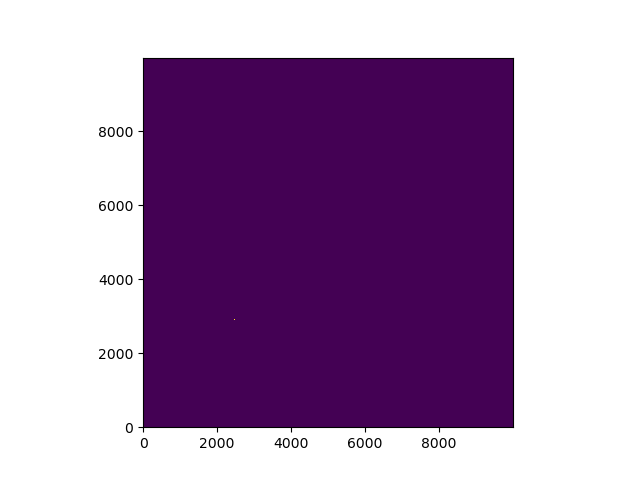

In [56]:
from matplotlib import pyplot as plt
%matplotlib ipympl

fig, ax = plt.subplots()
ax.imshow(im+1e-16, norm='log', vmin=1e4, vmax=1e6, interpolation='nearest', origin='lower')
ax.set_aspect(1)
plt.show()

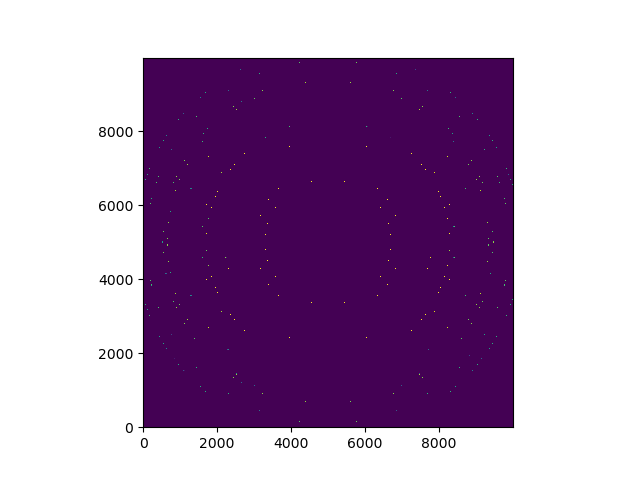

In [57]:
im, _, _ = np.histogram2d(sc, fc, weights=inten, bins=(sc_bins, fc_bins))

from matplotlib import pyplot as plt
%matplotlib ipympl

fig, ax = plt.subplots()
ax.imshow(im+1e-16, norm='log', vmin=1e4, vmax=1e6, interpolation='nearest', origin='lower')
ax.set_aspect(1)
plt.show()

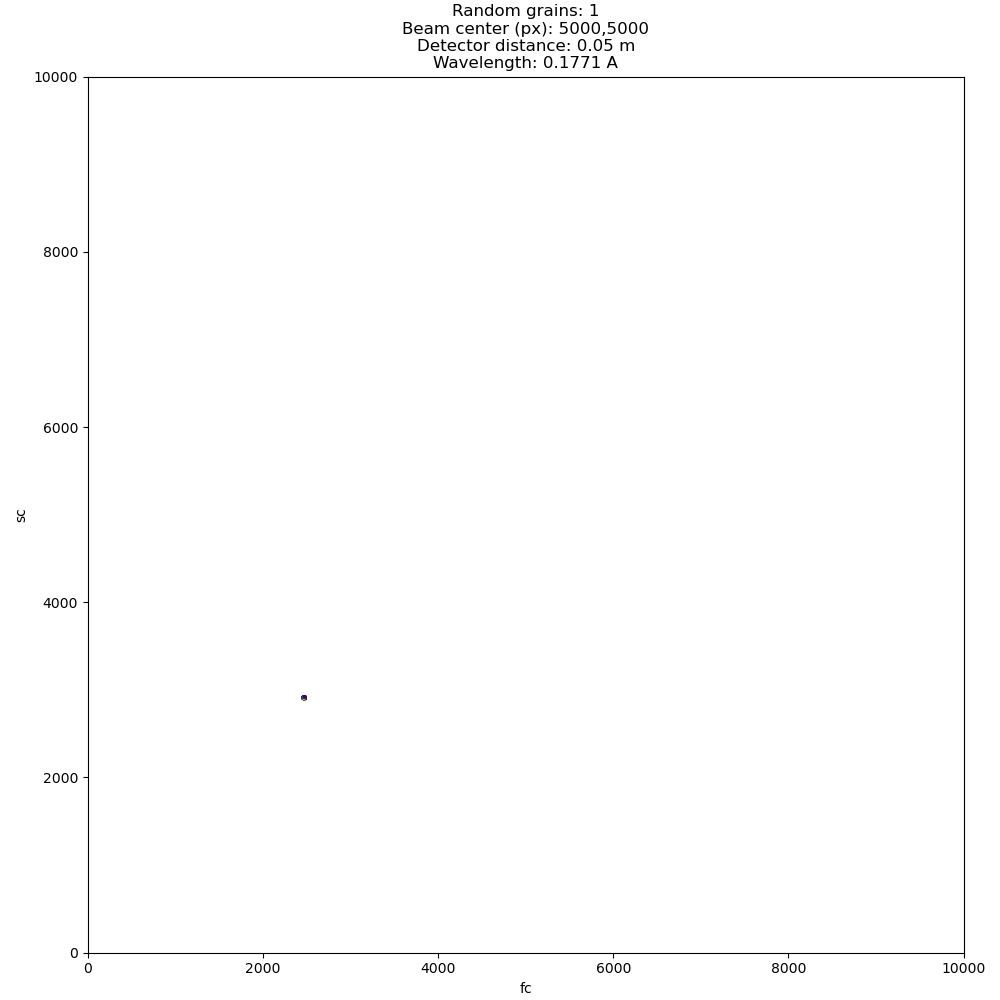

In [58]:
from matplotlib import pyplot as plt
%matplotlib ipympl

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,10))
ax.scatter(fc[m_ff], sc[m_ff], s=1, c=inten[m_ff])

ax.set_aspect(1)
ax.set(xlim=(0, npx), ylim=(0, npx))
ax.set(xlabel='fc', ylabel='sc',
       title=f"""Random grains: {ng}
Beam center (px): {pars.get('y_center')},{pars.get('z_center')}
Detector distance: {pars.get('distance')/1e6:.4} m
Wavelength: {pars.get('wavelength'):.4} A""")
plt.show()

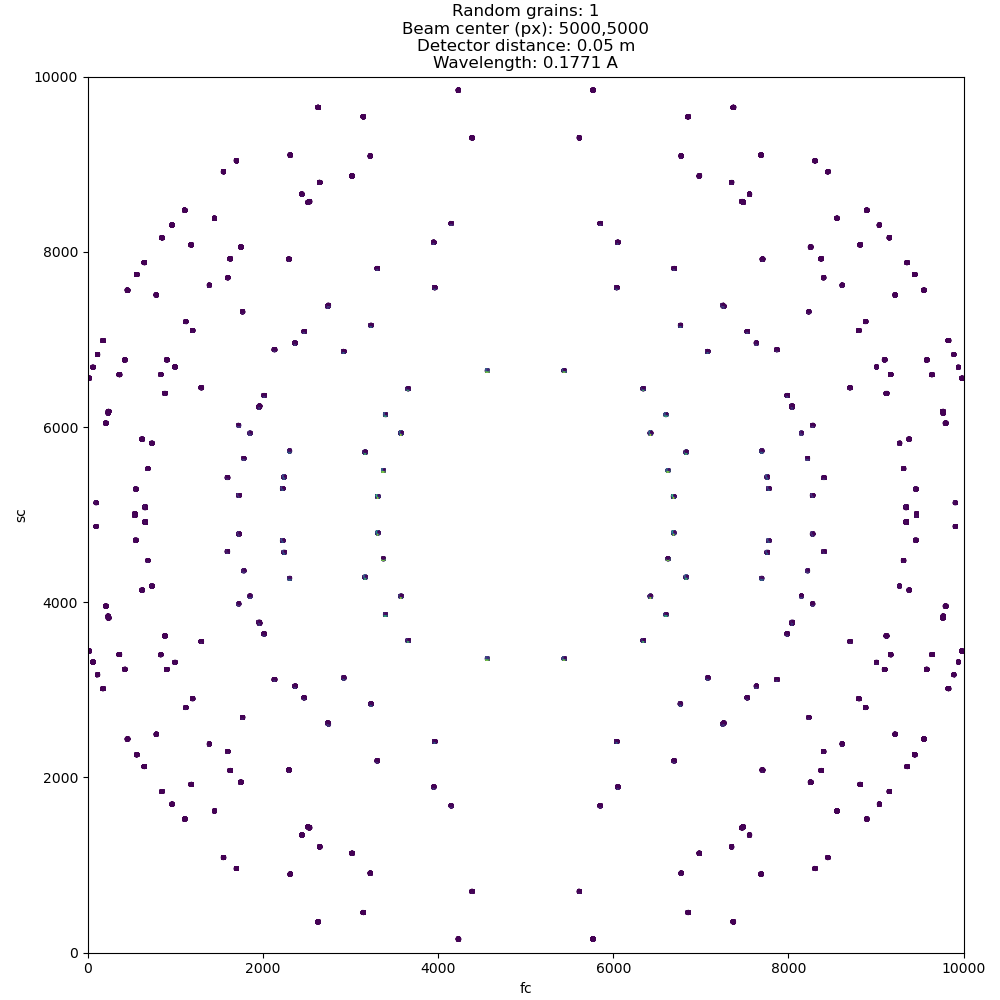

In [59]:
from matplotlib import pyplot as plt
%matplotlib ipympl

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,10))
ax.scatter(fc, sc, s=1, c=inten)

ax.set_aspect(1)
ax.set(xlim=(0, npx), ylim=(0, npx))
ax.set(xlabel='fc', ylabel='sc',
       title=f"""Random grains: {ng}
Beam center (px): {pars.get('y_center')},{pars.get('z_center')}
Detector distance: {pars.get('distance')/1e6:.4} m
Wavelength: {pars.get('wavelength'):.4} A""")
plt.show()

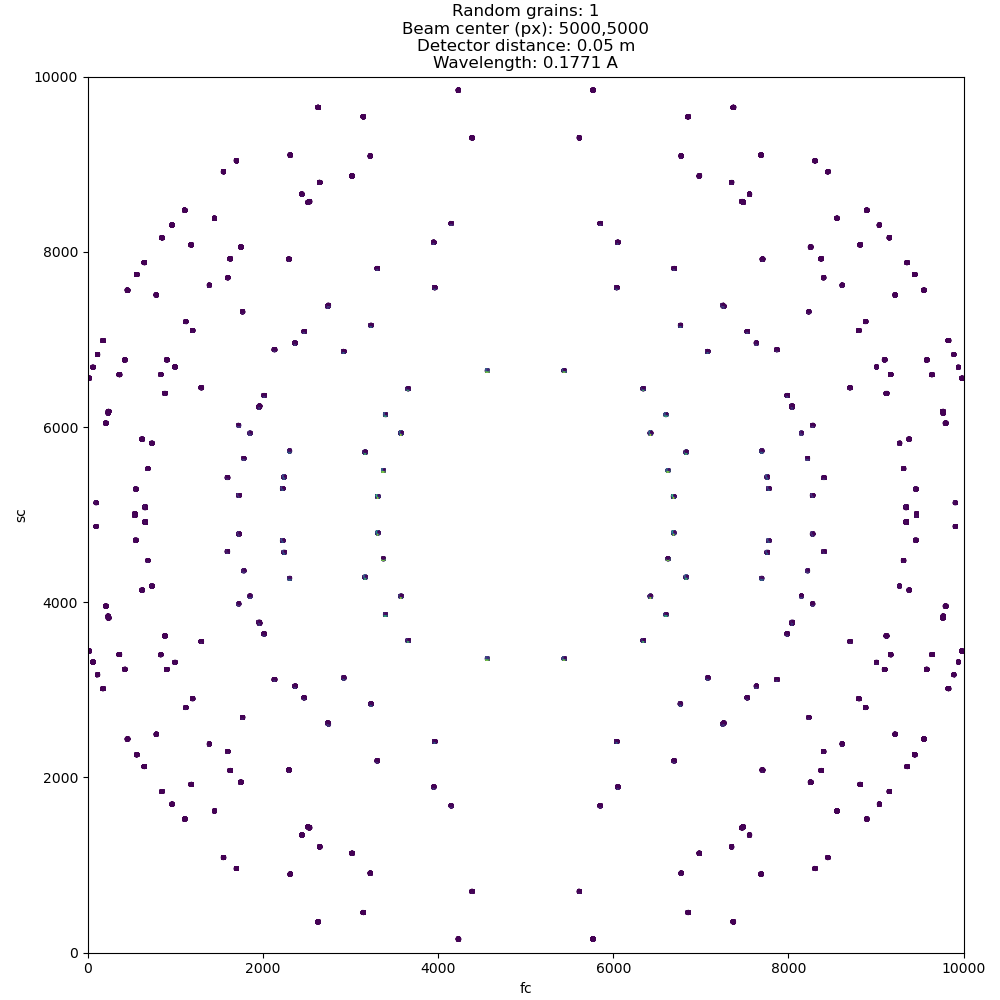

In [60]:
from matplotlib import pyplot as plt
%matplotlib ipympl

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,10))
ax.scatter(fc, sc, s=1, c=inten)

ax.set_aspect(1)
ax.set(xlim=(0, npx), ylim=(0, npx))
ax.set(xlabel='fc', ylabel='sc',
       title=f"""Random grains: {ng}
Beam center (px): {pars.get('y_center')},{pars.get('z_center')}
Detector distance: {pars.get('distance')/1e6:.4} m
Wavelength: {pars.get('wavelength'):.4} A""")
plt.show()